In [ ]:
# This Jupyter notebook walks you through scraping LinkedIn posts from the Boston Consulting Group using Selenium in Python. 
# We'll scroll the page, extract post text and timestamps, and analyze for sustainability mentions.

In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
# Launch Chrome and Navigate to LinkedIn
chrome_options = Options()
# Comment this out if you want to see the browser
# chrome_options.add_argument('--headless')
chrome_options.add_argument('--disable-gpu')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--window-size=1280,800')

service = Service()  # Use default path if chromedriver is in PATH
driver = webdriver.Chrome(service=service, options=chrome_options)

# Navigate to BCG's LinkedIn posts page
driver.get("https://www.linkedin.com/company/boston-consulting-group/posts/?feedView=all&viewAsMember=true")

# Pause to log in manually
input("⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue...")


⏸ Please log in to LinkedIn in the opened browser, then press [Enter] to continue... 


''

In [3]:
#testing the scraper 
SCROLL_PAUSE_TIME = 1  # seconds between scrolls
SCROLL_COUNT = 500  # adjust as needed

for i in range(500):  # start small for testing
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(SCROLL_PAUSE_TIME)
    print(f"✅ Scroll {i + 1} of {SCROLL_COUNT} complete")

print("Done scrolling.")

✅ Scroll 1 of 500 complete
✅ Scroll 2 of 500 complete
✅ Scroll 3 of 500 complete
✅ Scroll 4 of 500 complete
✅ Scroll 5 of 500 complete
✅ Scroll 6 of 500 complete
✅ Scroll 7 of 500 complete
✅ Scroll 8 of 500 complete
✅ Scroll 9 of 500 complete
✅ Scroll 10 of 500 complete
✅ Scroll 11 of 500 complete
✅ Scroll 12 of 500 complete
✅ Scroll 13 of 500 complete
✅ Scroll 14 of 500 complete
✅ Scroll 15 of 500 complete
✅ Scroll 16 of 500 complete
✅ Scroll 17 of 500 complete
✅ Scroll 18 of 500 complete
✅ Scroll 19 of 500 complete
✅ Scroll 20 of 500 complete
✅ Scroll 21 of 500 complete
✅ Scroll 22 of 500 complete
✅ Scroll 23 of 500 complete
✅ Scroll 24 of 500 complete
✅ Scroll 25 of 500 complete
✅ Scroll 26 of 500 complete
✅ Scroll 27 of 500 complete
✅ Scroll 28 of 500 complete
✅ Scroll 29 of 500 complete
✅ Scroll 30 of 500 complete
✅ Scroll 31 of 500 complete
✅ Scroll 32 of 500 complete
✅ Scroll 33 of 500 complete
✅ Scroll 34 of 500 complete
✅ Scroll 35 of 500 complete
✅ Scroll 36 of 500 complete
✅

In [4]:
#extract posts 

from selenium.webdriver.common.by import By
import pandas as pd

# Find all post containers
post_containers = driver.find_elements(By.CLASS_NAME, "feed-shared-update-v2")

post_texts = []
post_timestamps = []

for post in post_containers:
    try:
        # Post text
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""
        
#clean up timestamps
from selenium.webdriver.common.by import By
import re

post_texts = []
post_timestamps = []

for post in post_containers:
    # Extract post text
    try:
        text_elem = post.find_element(By.CLASS_NAME, "update-components-text")
        post_text = text_elem.text.strip()
    except:
        post_text = ""

    # Extract timestamp from the correct sub-description span
    try:
        sub_desc = post.find_element(By.CLASS_NAME, "update-components-actor__sub-description")
        time_span = sub_desc.find_element(By.XPATH, './/span[@aria-hidden="true"]')
        timestamp_raw = time_span.text.strip()
        match = re.search(r'\d+[a-z]+', timestamp_raw)  # e.g., "2mo", "1y"
        post_timestamp = match.group(0) if match else timestamp_raw
    except:
        post_timestamp = ""

    post_texts.append(post_text)
    post_timestamps.append(post_timestamp)

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Preview
df.head()

,timestamp,post
0,48m,"To do userful work, AI agents typically need a..."
1,15h,When a CEO is physically and mentally exhauste...
2,1d,What does it really take to deploy enterprise-...
3,1d,"For consumer products companies, AI is not opt..."
4,1d,Although tariff policies dominated Q2 earnings...


In [5]:
#export to CSV 
import pandas as pd

# Create DataFrame
df = pd.DataFrame({
    "timestamp": post_timestamps,
    "post": post_texts
})

# Save to CSV
df.to_csv("bcg_linkedin_posts.csv", index=False, encoding="utf-8")

print("Export complete: bcg_linkedin_posts.csv")

Export complete: bcg_linkedin_posts.csv


In [7]:
# setting up classification 
from openai import OpenAI
from IPython.display import display, Markdown
from tqdm.auto import tqdm
tqdm.pandas()

from dotenv import load_dotenv

In [8]:
df = pd.read_csv("bcg_linkedin_posts.csv")
df.dropna(subset=["post"], inplace=True)

In [9]:
#sample the data 
SIZE_OF_SAMPLE = min(50, len(df))  # ensures we don't sample more than we have
text_column_name = "post"

data_full = df.copy()
data_sample = data_full.sample(n=SIZE_OF_SAMPLE, random_state=42)

In [10]:
import os
from dotenv import load_dotenv

# Point to your .env file
load_dotenv(dotenv_path="/Users/klararehm/Desktop/final_project/.env")

# Retrieve API key securely
api_key = os.getenv("OPENAI_API_KEY")

# Confirm the API key has loaded 
print("✅ API key loaded." if api_key else "❌ API key not found.")

✅ API key loaded.


In [11]:
client = OpenAI(api_key=api_key)

In [12]:
from enum import Enum
from pydantic import BaseModel
from tqdm.auto import tqdm
tqdm.pandas()

# Define classification categories
class PostCategory(str, Enum):
    sustainability = "Sustainability / Green Growth / Climate"
    esg_social = "ESG – including DEI (Diversity, Equity & Inclusion)"
    ai_tech = "AI / Technology / Innovation"
    strategy = "Corporate Strategy / Business Management"
    geopolitics = "Geopolitics / International Affairs"
    hr = "HR / Talent / Culture & Inclusion"
    other = "Other"

# Prompt template
prompt_base = """
You are an expert social media analyst. Please categorize the following LinkedIn post into one of these categories to the best of your ability: {categories}

Post:
{text}
"""

categories = ", ".join([f'"{cat.value}"' for cat in PostCategory])
sample_prompts = data_sample.apply(lambda row: prompt_base.format(text=row["post"], categories=categories), axis=1)

# Format prompts
data_sample_prompt_column = data_sample.progress_apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

  0%|          | 0/50 [00:00<?, ?it/s]

In [13]:
#counting tokens for cost estimate 

import tiktoken

def count_tokens(model, text):
    encoding = tiktoken.encoding_for_model(model if model != 'gpt-4.1-mini' else 'gpt-4o')
    tokens = encoding.encode(text)
    return len(tokens)

input_token_costs = {
    "gpt-4.1-mini": 0.4 / 1_000_000,
    "mistral-medium-latest": 0.4 / 1_000_000,
    "mistral-large-latest": 2.0 / 1_000_000
}

def estimate_cost(model, token_count):
    return token_count * input_token_costs[model]

In [14]:
#determine OpenAI model to use and cost estimation helper 
MODEL_TO_USE = 'gpt-4.1-mini'
count_tokens_for_our_model = lambda text: count_tokens(MODEL_TO_USE, text)

full_data_prompt_column = data_full.apply(lambda row: prompt_base.format(
    text=row["post"],
    categories=", ".join([f'"{opt.value}"' for opt in PostCategory])
), axis=1)

In [15]:
# sample cost estimation 
token_count_sample = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(data_sample_prompt_column))
print("Sample would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_sample)))

Sample would cost: $0.0036


In [16]:
#cost estimate full dataset

token_count_full = count_tokens_for_our_model("SAMPLE RESPONSE SAMPLE RESPONSE".join(full_data_prompt_column))
print("Full dataset would cost: ${:.4f}".format(estimate_cost(MODEL_TO_USE, token_count_full)))


Full dataset would cost: $0.0209


In [17]:
# classification prompt 
class PostCategoryValidOptions(BaseModel):
    classification: PostCategory

def classify(prompt_including_post):
    messages = [
        {
            "role": "system",
            "content": "You are an expert social media analyst.",
        },
        {
            "role": "user",
            "content": prompt_including_post,
        }
    ]

    chat_completion = client.responses.parse(
        input=messages,
        model='gpt-4o',
        text_format=PostCategoryValidOptions,
    )
    return chat_completion.output_parsed.classification.value if chat_completion.output_parsed else None


In [18]:
data_full["ai_guess"] = full_data_prompt_column.progress_apply(classify)

  0%|          | 0/290 [00:00<?, ?it/s]

In [26]:
#Preview results 

from IPython.display import display, Markdown

display(Markdown("## Sample of classified posts"))
with pd.option_context("display.max_colwidth", 500):
    display(data_full[[text_column_name, "ai_guess"]].head(10))


## Sample of classified posts

,post,ai_guess
0,"To do userful work, AI agents typically need access to CRMs, ERPs, databases, messaging tools, and more. But as more agents and tools enter the ecosystem, integration becomes increasingly complex.\n\nModel Context Protocol (MCP) acts like a USB-C port for AI agents, serving as a universal connector that simplifies how LLMs link to tools and data.\n\nDiscover how MCP not only accelerates agent development but also enables smarter, more effective agents:",AI / Technology / Innovation
1,"When a CEO is physically and mentally exhausted, the entire company feels it. “If you don't have the mental space, the clarity, the conviction, and the energy to do the job, you are hamstringing the enterprise,” says BCG’s Christine Barton.\n\nBut there are actions CEOs can take to spot the signs of burnout and build greater physical and mental resilience. Read more here:",Corporate Strategy / Business Management
2,"What does it really take to deploy enterprise-ready AI agents?\n\nThey’re not plug and play. You need clear processes, quality data, API access, and a workforce ready to engage. Without those, agents can’t deliver value.\n\nIn thisseries, BCG’sexplores how AI agents are driving transformative change.",AI / Technology / Innovation
3,"For consumer products companies, AI is not optional. It’s already everywhere around them.\n\nTo compete, they must embed AI at their core, becoming faster, leaner, and more innovative. Since they can’t be rebuilt from scratch, the shift to AI-first must be gradual, starting with optimizing workflows and eventually building new AI-driven businesses.\n\nTo learn how your organization can begin this journey, explore our full report here:",AI / Technology / Innovation
4,"Although tariff policies dominated Q2 earnings calls, a related concern is also weighing on CEOs’ minds: that trade disruptions may lead to an economic downturn.\n\nThat’s the key finding of the third edition of the CEO Radar, an AI-powered analysis from BCG andStudios.\n\nHalfway through 2025, the view is decidedly cloudy from both CEOs and analysts. According to BCG's Global Chair, ""I do think that CEOs are more anxious about the economy...The level of economic uncertainty is higher.""\n\nR...",Geopolitics / International Affairs
5,"India’s steel industry is on track to triple by 2050. And the country’s largest steel producer, JSW Steel plays a pivotal role in making sure that growth is green.\n\nIn partnership with BCG, JSW launched SEED (Sustainable, Energy, Environment and Decarbonization) in 2022, an initiative focused on decarbonizing operations.\n\nDiscover how BCG and JSW are reshaping the future of the steel industry:",Sustainability / Green Growth / Climate
6,"From Milan to Lisbon, Alessia Soffientini’s BCG journey is one of growth, leadership, and impact.\n\nAs a Team Manager at the Lisbon Capability Center (LCC), a fast-growing hub supporting BCG’s global operations, she is shaping culture, mentoring new colleagues, and helping build a strong team from the ground up.\n\nRead the full blog post to see what makes the LCC a place full of opportunity, collaboration, and connection:",Corporate Strategy / Business Management
7,"How are BCG and ServiceNow helping organizations scale digital transformation more effectively?\n\nServiceNow’sjoined BCG’sandto unpack common challenges in transformation efforts, including misalignment between business priorities and tech investments and underinvestment in change management.",AI / Technology / Innovation
8,"Mark helps global companies personalize at scale. \n\nStep 1? Understand people. \n\nAt BCG,has guided the firm’s work in personalization and responsible AI, helping clients use data to create experiences that feel human, not just automated.\n\nHis career reflects what thoughtful leadership looks like in practice, especially in moments of change.\n\nLearn how Mark’s perspective helps to shape how organizations grow, adapt, and connect:",AI / Technology / Innovation
9,"Wher

In [27]:
#save to CSV 
data_full.to_csv("bcg_linkedin_classified.csv", index=False)

In [28]:
pd.read_csv("bcg_linkedin_classified.csv")

,timestamp,post,ai_guess
0,48m,"To do userful work, AI agents typically need a...",AI / Technology / Innovation
1,15h,When a CEO is physically and mentally exhauste...,Corporate Strategy / Business Management
2,1d,What does it really take to deploy enterprise-...,AI / Technology / Innovation
3,1d,"For consumer products companies, AI is not opt...",AI / Technology / Innovation
4,1d,Although tariff policies dominated Q2 earnings...,Geopolitics / International Affairs
...,...,...,...
285,8mo,With the recent wave of innovation in AI and g...,AI / Technology / Innovation
286,8mo,As the automotive industry accelerates toward ...,AI / Technology / Innovation
287,8mo,"To transform businesses with AI, simply upgrad...",AI / Technology / Innovation
288,8mo,"We recently surveyed 770 CEOs, CFOs, and COOs ...",AI / Technology / Innovation


In [38]:
df_bcg_classified = pd.read_csv("bcg_linkedin_classified.csv")

In [39]:
df_bcg_classified.head()

,timestamp,post,ai_guess
0,48m,"To do userful work, AI agents typically need a...",AI / Technology / Innovation
1,15h,When a CEO is physically and mentally exhauste...,Corporate Strategy / Business Management
2,1d,What does it really take to deploy enterprise-...,AI / Technology / Innovation
3,1d,"For consumer products companies, AI is not opt...",AI / Technology / Innovation
4,1d,Although tariff policies dominated Q2 earnings...,Geopolitics / International Affairs


In [40]:
#filter out duplicates 

duplicate_count = df_bcg_classified.duplicated(subset="post").sum()
print(f"Number of duplicate posts: {duplicate_count}")

Number of duplicate posts: 1


In [45]:
df_bcg_classified = df_bcg_classified.drop_duplicates(subset="post", keep="first")

In [47]:
#add normalised timestamp 
import re
from datetime import datetime, timedelta

def normalize_timestamp(rel_time):
    today = datetime.today()

    if pd.isna(rel_time) or not isinstance(rel_time, str):
        return None

    rel_time = rel_time.strip().replace(" ", "")
    
    match = re.match(r"(\d+)([a-zA-Z]+)", rel_time)
    if not match:
        return None

    value, unit = int(match.group(1)), match.group(2).lower()

    if unit.startswith("h"):       # hours ago → today
        return today.date()
    elif unit.startswith("d"):     # days
        return (today - timedelta(days=value)).date()
    elif unit.startswith("w"):     # weeks
        return (today - timedelta(weeks=value)).date()
    elif unit.startswith("mo"):    # months (approximate)
        return (today - timedelta(days=30 * value)).date()
    elif unit.startswith("y"):     # years (approximate)
        return (today - timedelta(days=365 * value)).date()
    else:
        return None

# Apply to  classified df 
df_bcg_classified["normalized_date"] = df_bcg_classified["timestamp"].apply(normalize_timestamp)

# Preview results
df_bcg_classified.head()

,timestamp,post,ai_guess,normalized_date
0,48m,"To do userful work, AI agents typically need a...",AI / Technology / Innovation,None
1,15h,When a CEO is physically and mentally exhauste...,Corporate Strategy / Business Management,2025-08-07
2,1d,What does it really take to deploy enterprise-...,AI / Technology / Innovation,2025-08-06
3,1d,"For consumer products companies, AI is not opt...",AI / Technology / Innovation,2025-08-06
4,1d,Although tariff policies dominated Q2 earnings...,Geopolitics / International Affairs,2025-08-06


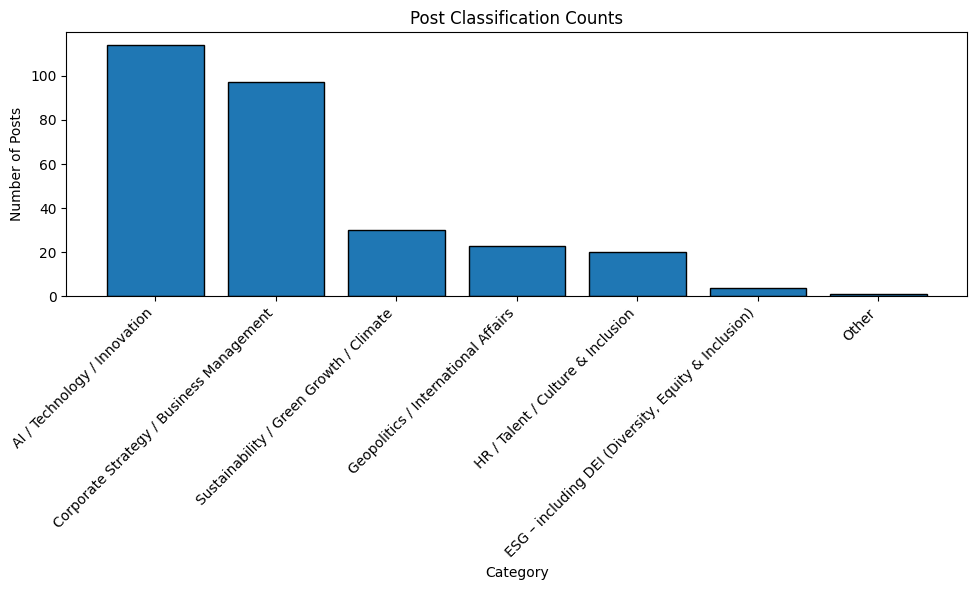

In [63]:
#visualise the results 

import matplotlib.pyplot as plt

# Count the categories
category_counts = df_bcg_classified["ai_guess"].value_counts()

# Create bar chart manually for better alignment
plt.figure(figsize=(10, 6))
bars = plt.bar(category_counts.index, category_counts.values, edgecolor='black')

# Add labels and formatting
plt.title("Post Classification Counts")
plt.xlabel("Category")
plt.ylabel("Number of Posts")
plt.xticks(ticks=range(len(category_counts.index)), labels=category_counts.index, rotation=45, ha='right')
plt.tight_layout()
plt.show()



<Figure size 1400x700 with 0 Axes>

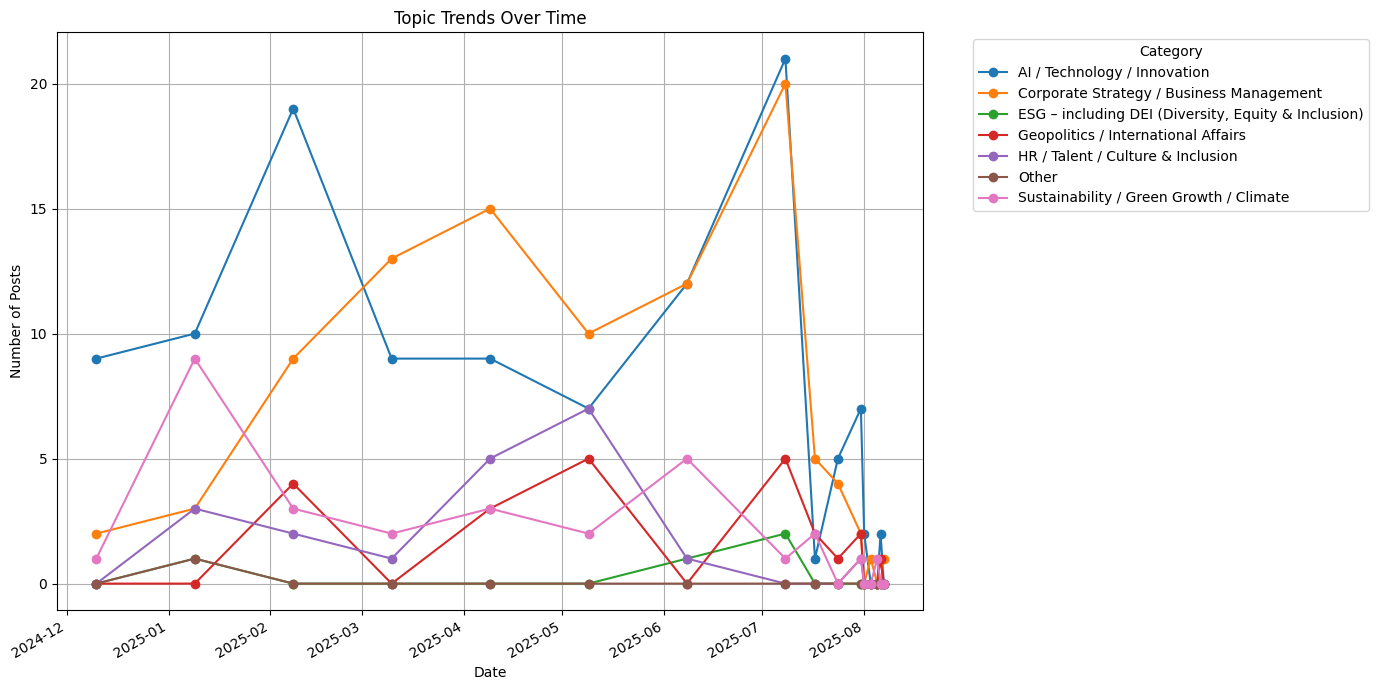

In [51]:
#trends over time 

import matplotlib.pyplot as plt

# Ensure normalized date is datetime
df_bcg_classified["normalized_date"] = pd.to_datetime(df_bcg_classified["normalized_date"])

# Group by date and category, then count
trend_data = df_bcg_classified.groupby(["normalized_date", "ai_guess"]).size().unstack(fill_value=0)

# Plot
plt.figure(figsize=(14, 7))
trend_data.plot(kind='line', marker='o', figsize=(14, 7))

plt.title("Topic Trends Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

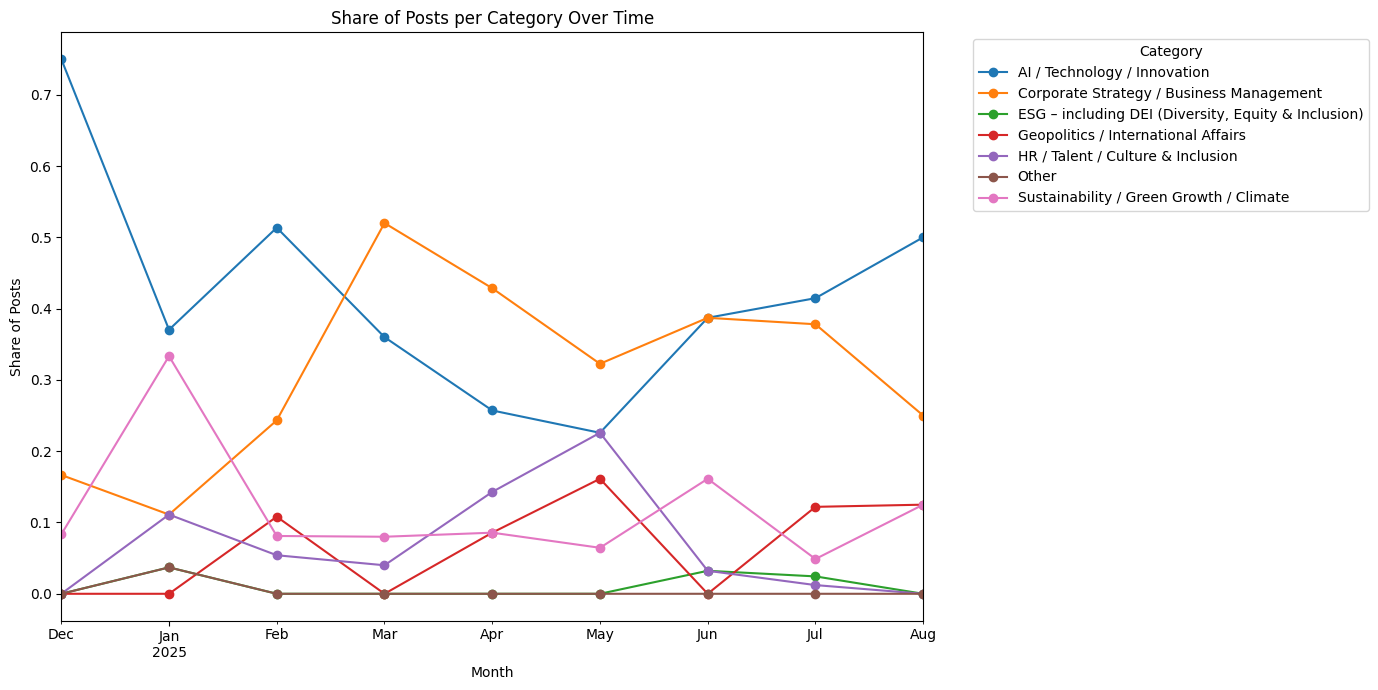

In [53]:
#what is the monthly share of posts in each category? 
df_bcg_classified["month"] = df_bcg_classified["normalized_date"].dt.to_period("M")

monthly_counts = df_bcg_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)

monthly_shares = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# Plot
monthly_shares.plot(figsize=(14, 7), marker='o')
plt.title("Share of Posts per Category Over Time")
plt.xlabel("Month")
plt.ylabel("Share of Posts")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



In [56]:
# monthly shares as percentages in table format 

df_bcg_classified["month"] = df_bcg_classified["normalized_date"].dt.to_period("M")

#Count posts by month and category
monthly_counts = df_bcg_classified.groupby(["month", "ai_guess"]).size().unstack(fill_value=0)
monthly_total = monthly_counts.sum(axis=1)

#Calculate shares (in percentage)
monthly_shares_pct = monthly_counts.div(monthly_counts.sum(axis=1), axis=0) * 100
monthly_shares_pct = monthly_shares_pct.round(1)  # round to 1 decimal place
monthly_shares_pct["Total Posts"] = monthly_total

# Display as table
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)  # show all columns
display(monthly_shares_pct)

ai_guess,AI / Technology / Innovation,Corporate Strategy / Business Management,"ESG – including DEI (Diversity, Equity & Inclusion)",Geopolitics / International Affairs,HR / Talent / Culture & Inclusion,Other,Sustainability / Green Growth / Climate,Total Posts
month,,,,,,,,
2024-12,75.0,16.7,0.0,0.0,0.0,0.0,8.3,12
2025-01,37.0,11.1,3.7,0.0,11.1,3.7,33.3,27
2025-02,51.4,24.3,0.0,10.8,5.4,0.0,8.1,37
2025-03,36.0,52.0,0.0,0.0,4.0,0.0,8.0,25
2025-04,25.7,42.9,0.0,8.6,14.3,0.0,8.6,35
2025-05,22.6,32.3,0.0,16.1,22.6,0.0,6.5,31
2025-06,38.7,38.7,3.2,0.0,3.2,0.0,16.1,31
2025-07,41.5,37.8,2.4,12.2,1.2,0.0,4.9,82
2025-08,50.0,25.0,0.0,12.5,0.0,0.0,12.5,8


In [57]:
#82 posts for July seems very high 

df_bcg_classified["month"] = df_bcg_classified["normalized_date"].dt.to_period("M")
df_bcg_classified["month"].value_counts().sort_index()

month
2024-12    12
2025-01    27
2025-02    37
2025-03    25
2025-04    35
2025-05    31
2025-06    31
2025-07    82
2025-08     8
Freq: M, Name: count, dtype: int64

In [60]:
# Filter for July
july_df = df_bcg_classified[df_bcg_classified["month"] == "2025-07"]

# Count duplicates
july_duplicates = july_df.duplicated(subset="post").sum()
print(f"Duplicate posts in July: {july_duplicates}")


Duplicate posts in July: 0


In [61]:
july_df[["timestamp", "normalized_date", "post"]].head(10)

,timestamp,normalized_date,post
9,1w,2025-07-31,Where is opportunity knocking for companies lo...
10,1w,2025-07-31,"Global tariff dynamics are shifting, and compa..."
11,1w,2025-07-31,Top retailers aren’t just outperforming. They ...
12,1w,2025-07-31,"Just one year since opening its doors, BCG’s L..."
13,1w,2025-07-31,The world may run short of critical raw materi...
14,1w,2025-07-31,AI takes trends and market research and turns ...
15,1w,2025-07-31,GLP-1 medications have created a $60–90B pharm...
16,1w,2025-07-31,How do you bring GenAI into your daily workflo...
17,1w,2025-07-31,Stay informed on the latest tariff insights wi...
18,1w,2025-07-31,Complex environments don't halt deals; they in...


In [64]:
#save as csv file 
df_bcg_classified.to_csv("df_bcg_classified.csv", index=False)
